# Kakao talk 대화 분석

이 프로젝트는 오픈윙스님의 [데이터로 풀어보는 나] 이메일로 분석해 보는 나의 3년( http://goodvc.tistory.com/14 )로 영감을 받아, 단톡방에서 혼자 외롭게 소리없는 아우성을 지르는 저를 정성적으로 나타내어 보고 친구들에게 매마른 감정을 돌아보게 하는 목표를 가지고 있습니다.

일부 코드는 그대로 옮겨왔으므로, 이 지면을 빌려 양해를 구합니다.

In [81]:
text_file = open('KakaoTalk_20150823_2347_04_589_group.txt', 'r', encoding="utf8")

lines = text_file.readlines()   

In [82]:
# coding: utf-8
import re
import datetime
from datetime import date
import time
import numpy as np
from pandas import *
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns

%matplotlib inline
sns.set_style("whitegrid")
rcParams['font.family'] = 'NanumGothic'
rcParams.update({'font.size': 12})

In [83]:
date_pattern = re.compile("-{15} (\d+)년 (\d+)월 (\d+)일 ([월, 화, 수, 목, 금, 토, 일]+)요일 -{15}")
message_pattern = re.compile("\[([\w+|\s+]+)\] \[([오후, 오전]+ \d+:\d+)\] (.+)")
messages = []
date_now = date.today()
for idx, line in enumerate(lines):    
    date_match = date_pattern.match(line)
    message_match = message_pattern.match(line)
    if date_match:
        date_now = date(int(date_match.group(1)), int(date_match.group(2)), int(date_match.group(3)))                        
    elif message_match:         
        name = message_match.group(1)
        send_time = message_match.group(2)
        content = message_match.group(3)
        
        send_time = datetime.strptime(send_time.replace('오후','pm').replace('오전','am'), '%p %I:%M').time()        
        send_datetime = datetime.combine(date_now, send_time)
        message_item = {'name':name, 'date':date_now, 'timestamp':send_datetime, 'content':content} # type 추가 예정
        messages.append(message_item)                
        
        

In [84]:
df = DataFrame(messages)
df['hour'] = df['timestamp'].apply( lambda x : x.hour+ x.minute/60)

C:\Python34\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


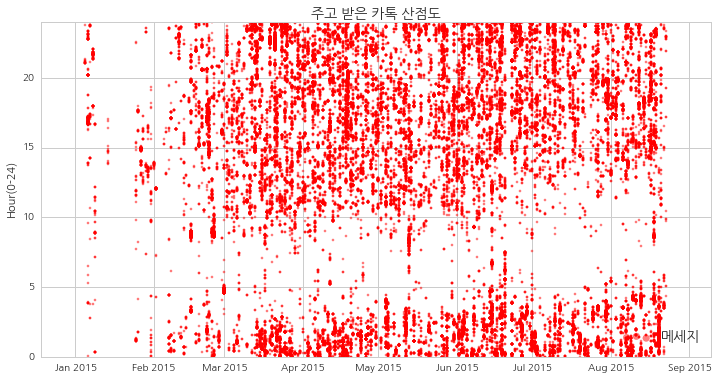

In [85]:
plt.figure(figsize=(12,6))
plt.scatter(df.date.tolist(), df.hour.tolist(), s=5, alpha=0.5, color='r', label='메세지')
plt.ylim(0,24)
plt.ylabel('Hour(0-24)')
plt.title("주고 받은 카톡 산점도",fontsize=14)
plt.legend(scatterpoints=3,
           loc='lower right',
           ncol=3,
           fontsize=14, markerscale = 3) 
plt.show()

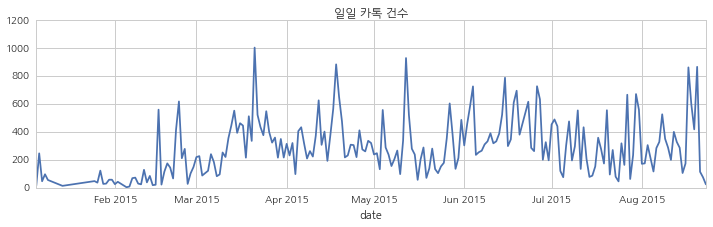

In [86]:
df.groupby('date').count()['timestamp'].plot(kind='line', figsize=(12,3))
plt.title('일일 카톡 건수')
plt.show()

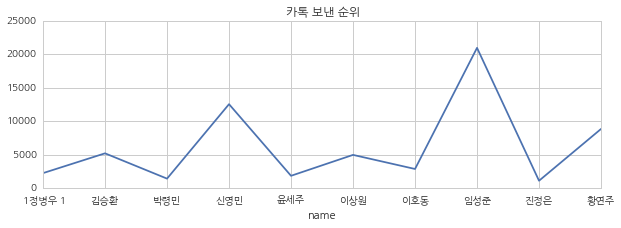

In [87]:
count_df = df.groupby('name').count()['content']
count_df.plot(kind='line', figsize=(10,3))
plt.title('카톡 보낸 순위')
plt.show()

In [88]:
df['delta'] = (df['timestamp'].shift(-1)-df['timestamp']).fillna(0)
df['is_indifferent'] = ((df['name'] != df['name'].shift(-1)) & (df['delta'].dt.seconds//60 >= 10))

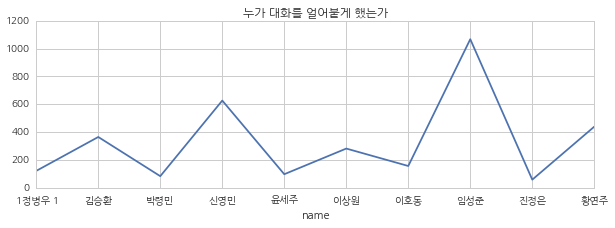

In [89]:
#print(df[['is_indifferent', 'name', 'timestamp', 'delta', 'content']])
cold_df = df[df['is_indifferent']].groupby('name').count()['content']
cold_df.plot(kind='line', figsize=(10,3))
plt.title('누가 대화를 얼어붙게 했는가')
plt.show()

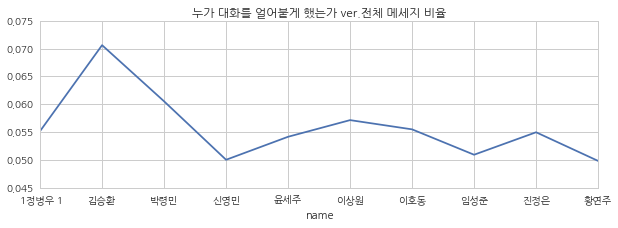

In [90]:
df[df['is_indifferent']].groupby('name').count()['content'].div(count_df).plot(kind='line', figsize=(10,3))
plt.title('누가 대화를 얼어붙게 했는가 ver.전체 메세지 비율')
plt.show()

시간대 별 카톡 통계를 해보겠다.

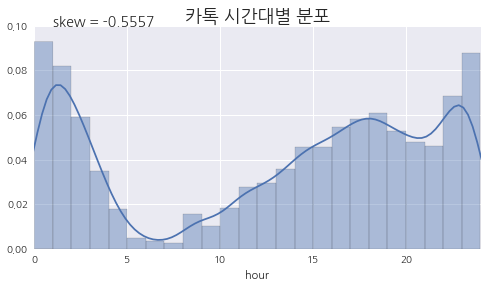

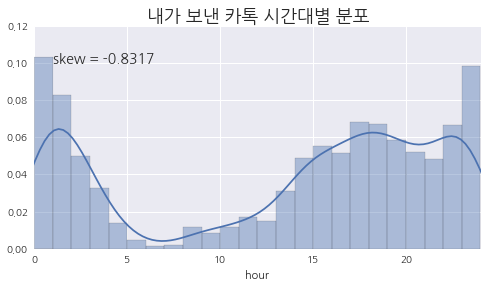

In [91]:
## day 
sns.set_style("darkgrid")
rcParams['font.family'] = 'NanumGothic'
rcParams.update({'font.size': 12})

def distplot(ds, col, title=''):
    plt.figure(figsize=(8,4))
    sns.distplot (ds[col], bins=24 )
    plt.xlim(0,24)
    skew = ds[(ds[col]>8) & (ds[col]<19 )][col].skew()
    skew = "skew = {0}".format(round(skew, 4))
    plt.text(1,0.1,skew, fontsize=14)
    plt.title(title, fontdict = {'fontsize': 18} )
    plt.show()
    
distplot(df, 'hour', '카톡 시간대별 분포')
distplot(df[df['name'] == '신영민'], 'hour', '내가 보낸 카톡 시간대별 분포')

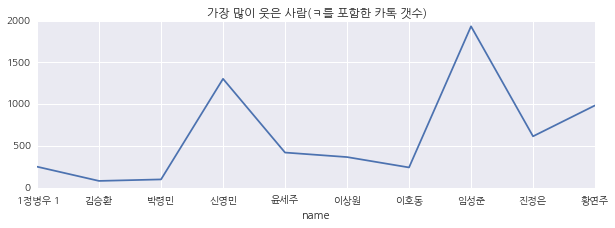

In [92]:
df[df['content'].str.contains("ㅋ")].groupby('name').count()['content'].plot(kind='line', figsize=(10,3))
plt.title('가장 많이 웃은 사람(ㅋ를 포함한 카톡 갯수)')
plt.show()

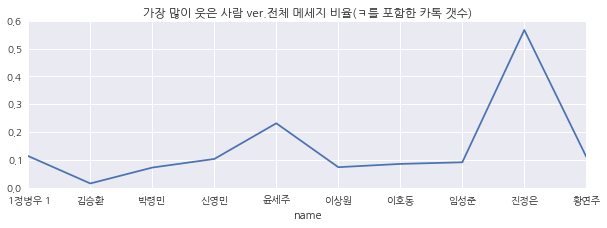

In [93]:
df[df['content'].str.contains("ㅋ")].groupby('name').count()['content'].div(count_df).plot(kind='line', figsize=(10,3))
plt.title('가장 많이 웃은 사람 ver.전체 메세지 비율(ㅋ를 포함한 카톡 갯수)')
plt.show()

C:\Python34\lib\site-packages\pandas\core\strings.py:207: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  " groups, use str.extract.", UserWarning)


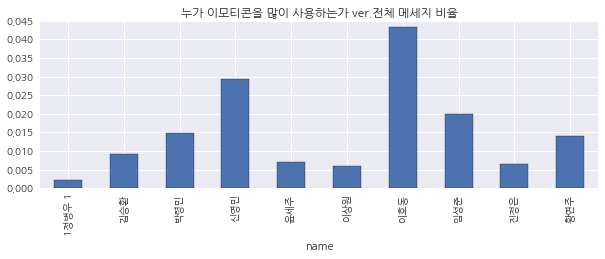

In [111]:
df[df['content'].str.contains('(emoticon)|(이모티콘)')].groupby('name').count()['content'].div(count_df).plot(kind='bar', figsize=(10,3))
plt.title('누가 이모티콘을 많이 사용하는가 ver.전체 메세지 비율')
plt.show()